In [1]:
from jcm import model as mod

def test_speedy_model(time_step=120, save_interval=1, total_time=1, layers=8):
    from dinosaur import primitive_equations_states

    model = mod.SpeedyModel(
        time_step=time_step,
        save_interval=save_interval,
        total_time=total_time,
        layers=layers,
    )

    state = model.get_initial_state()
    q_perturbation = primitive_equations_states.gaussian_scalar(model.coords, model.physics_specs)
    q_perturbation = model.coords.horizontal.to_modal(
        1e-4 * model.coords.horizontal.to_nodal(q_perturbation)
    ) # nodal/modal transform should be linear but not taking chances
    state.tracers = {'specific_humidity': q_perturbation}

    final_state, predictions = model.unroll(state)

    return final_state, predictions, model

In [2]:
import jax

jax.config.update('jax_disable_jit', True)
jax.config.update("jax_debug_infs", True)
jax.config.update("jax_debug_nans", True)
final_state, predictions, model = test_speedy_model(time_step=30, save_interval=1, total_time=2, layers=7)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


tmin, tmax:  270.0 288.0
q:  -1.1653915e-08 0.09979316
tmin, tmax:  270.07022 287.8742
q:  -0.41135433 1.0545897
tmin, tmax:  270.13983 287.7607
q:  -0.51346666 1.9497606
tmin, tmax:  270.20966 287.72702
q:  -2.390891 2.512208
tmin, tmax:  270.27942 287.57352
q:  -0.3976977 3.1506882
tmin, tmax:  270.34866 287.4606
q:  -1.4871782 3.7154667
tmin, tmax:  270.41788 287.32477
q:  -1.0702643 5.4867024
tmin, tmax:  270.4866 287.21774
q:  -0.5841468 5.25223
tmin, tmax:  270.5556 287.117
q:  -0.5542695 5.114563
tmin, tmax:  270.62436 287.02707
q:  -1.1403742 5.482674
tmin, tmax:  270.69214 286.9285
q:  -0.39506507 5.8635254
tmin, tmax:  270.76 286.83496
q:  -0.6369498 6.1975636
tmin, tmax:  270.82834 286.747
q:  -1.0707773 6.5132866
tmin, tmax:  270.89703 286.66064
q:  -0.41529036 6.766421
tmin, tmax:  270.9665 286.5781
q:  -0.59499013 6.9129176
tmin, tmax:  271.03677 286.50055
q:  -0.75502056 7.1522436
tmin, tmax:  271.10794 286.42267
q:  -0.29568475 7.3058367
tmin, tmax:  271.17984 286.34775

putting temperature variation in a to_modal(to_nodal) in physics code added 20 seconds to a 100 second run? revisit when profiling

In [3]:
from dinosaur import primitive_equations as pe
from dinosaur import spherical_harmonic as sh
from dinosaur.scales import units
import numpy as np

coords = model.coords

diagnostic_final_state = pe.compute_diagnostic_state(final_state, coords)
print('Computed nodal quantities:\n' + '\n'.join(diagnostic_final_state.__dataclass_fields__.keys()))
log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)

u_nodal, v_nodal = sh.vor_div_to_uv_nodal(coords.horizontal, final_state.vorticity, final_state.divergence)
w_nodal = pe.compute_vertical_velocity(final_state, coords)

u_nodal, v_nodal, w_nodal = (model.physics_specs.dimensionalize(u, units.meter / units.second).m 
                             for u in (u_nodal, v_nodal, w_nodal))
surface_pressure_nodal = np.exp(log_surface_pressure_nodal) * 1e5
q_nodal = model.physics_specs.dimensionalize(
    diagnostic_final_state.tracers['specific_humidity'], units.gram / units.kilogram
).m
t_nodal = np.linspace(270, 288, q_nodal.shape[0])[:, np.newaxis, np.newaxis] + model.physics_specs.dimensionalize(
                diagnostic_final_state.temperature_variation, units.kelvin
            ).m

Computed nodal quantities:
vorticity
divergence
temperature_variation
cos_lat_u
sigma_dot_explicit
sigma_dot_full
cos_lat_grad_log_sp
u_dot_grad_log_sp
tracers


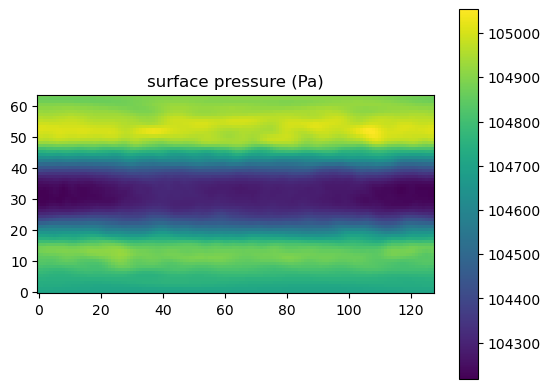

In [9]:
import matplotlib.pyplot as plt

plt.imshow(surface_pressure_nodal[0,:,:].T)
plt.gca().invert_yaxis()
plt.title('surface pressure (Pa)')
plt.colorbar()
plt.show()

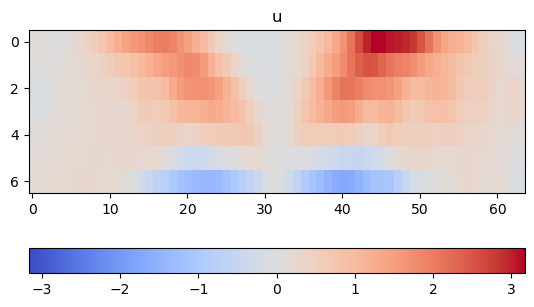

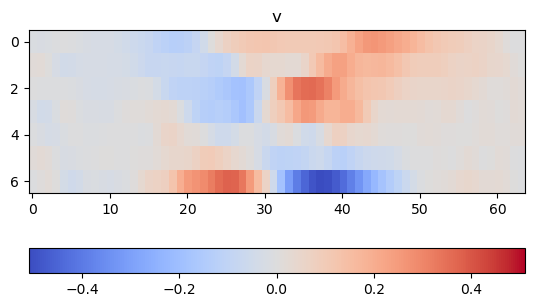

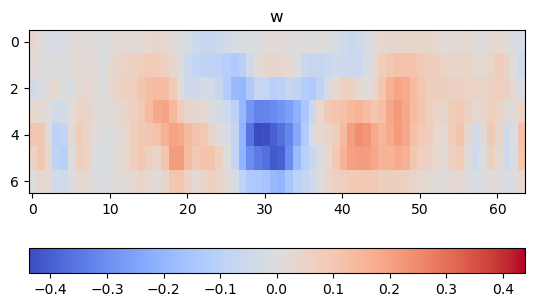

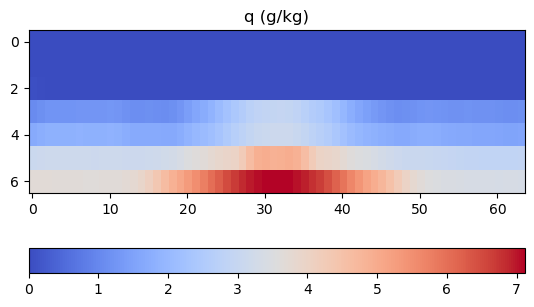

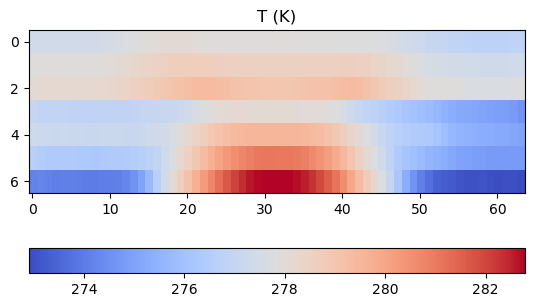

In [8]:
def plot_variable(variable, title, vmin=None, vmax=None, positive=False):
    data = np.mean(variable, axis=1)
    if positive: 
        vmin = np.min(data) if vmin is None else vmin
    else:
        vmin = min(np.min(data), -np.max(data)) if vmin is None else vmin
    vmax = max(np.max(data), -np.min(data)) if vmax is None else vmax
    plt.imshow(data, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect=3)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    plt.show()

plot_variable(u_nodal, 'u')
plot_variable(v_nodal, 'v')
plot_variable(w_nodal, 'w')
plot_variable(q_nodal, 'q (g/kg)', vmin=0)
plot_variable(t_nodal, 'T (K)', positive=True)

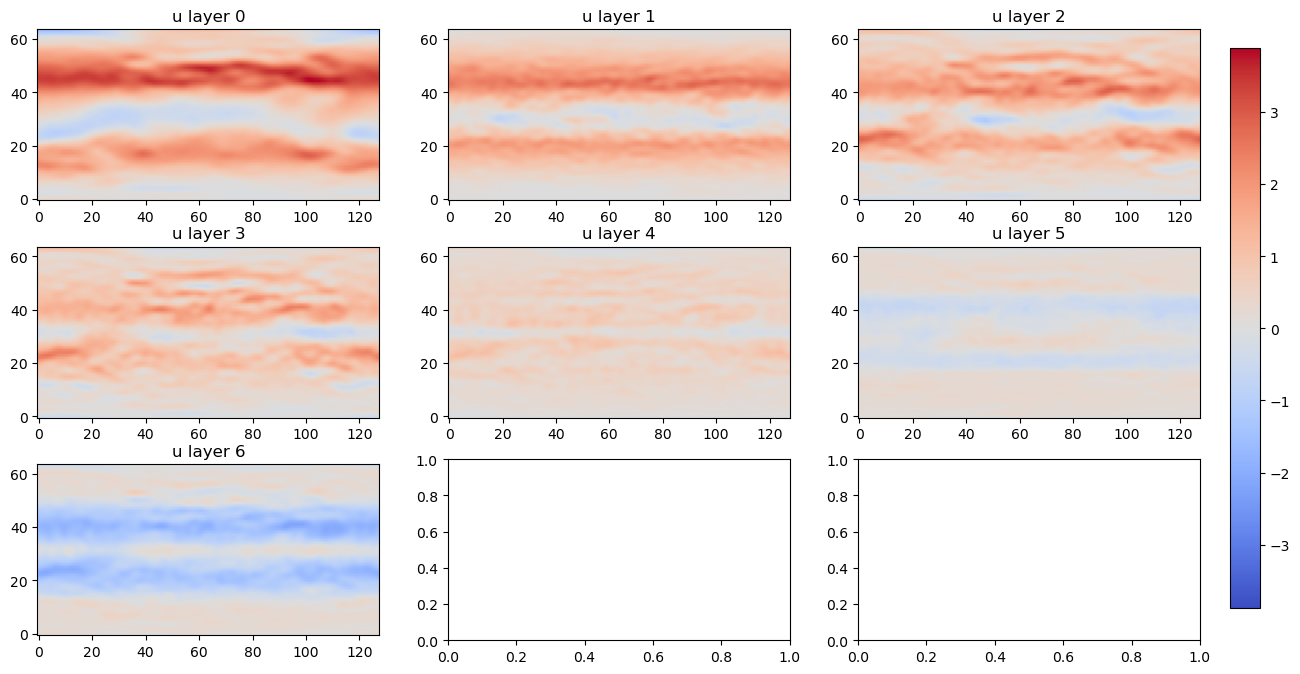

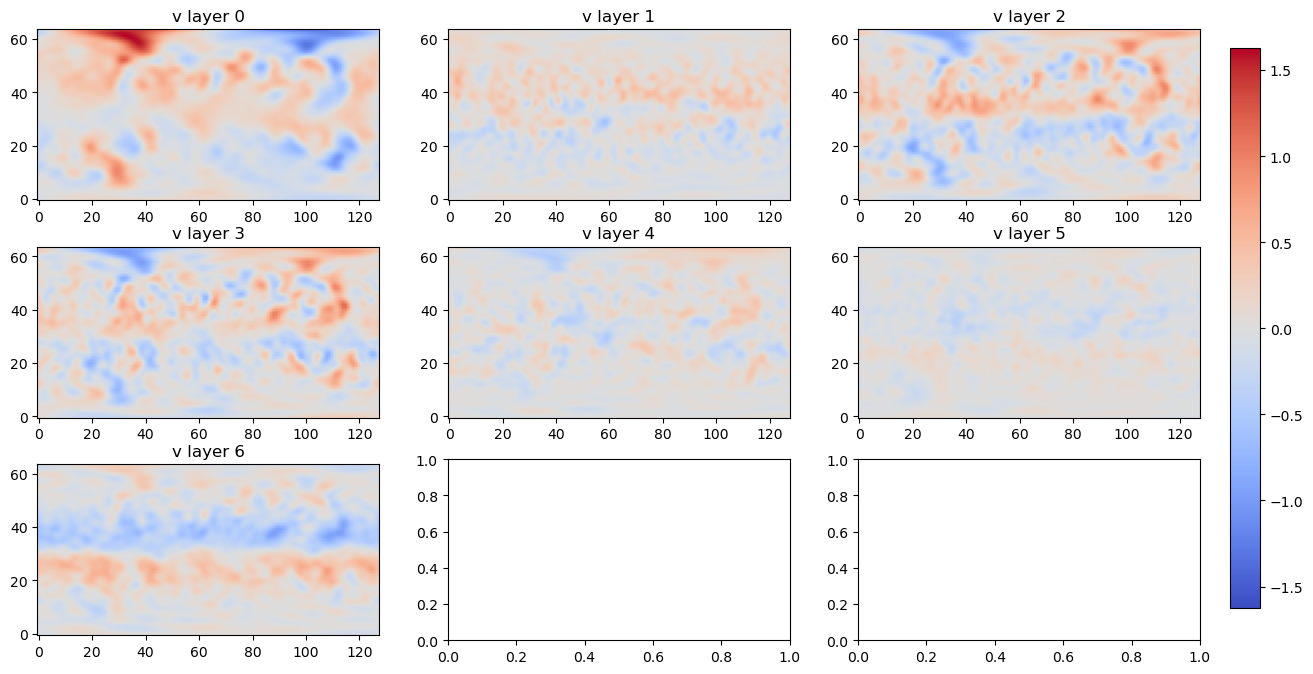

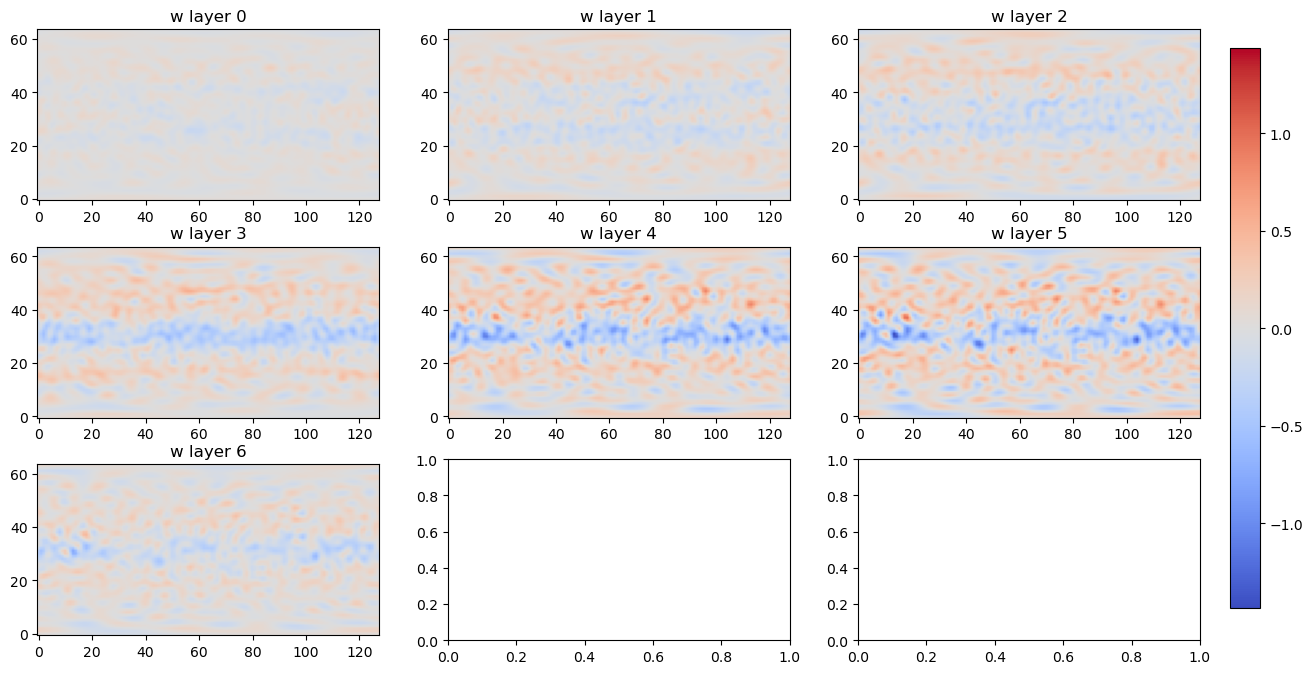

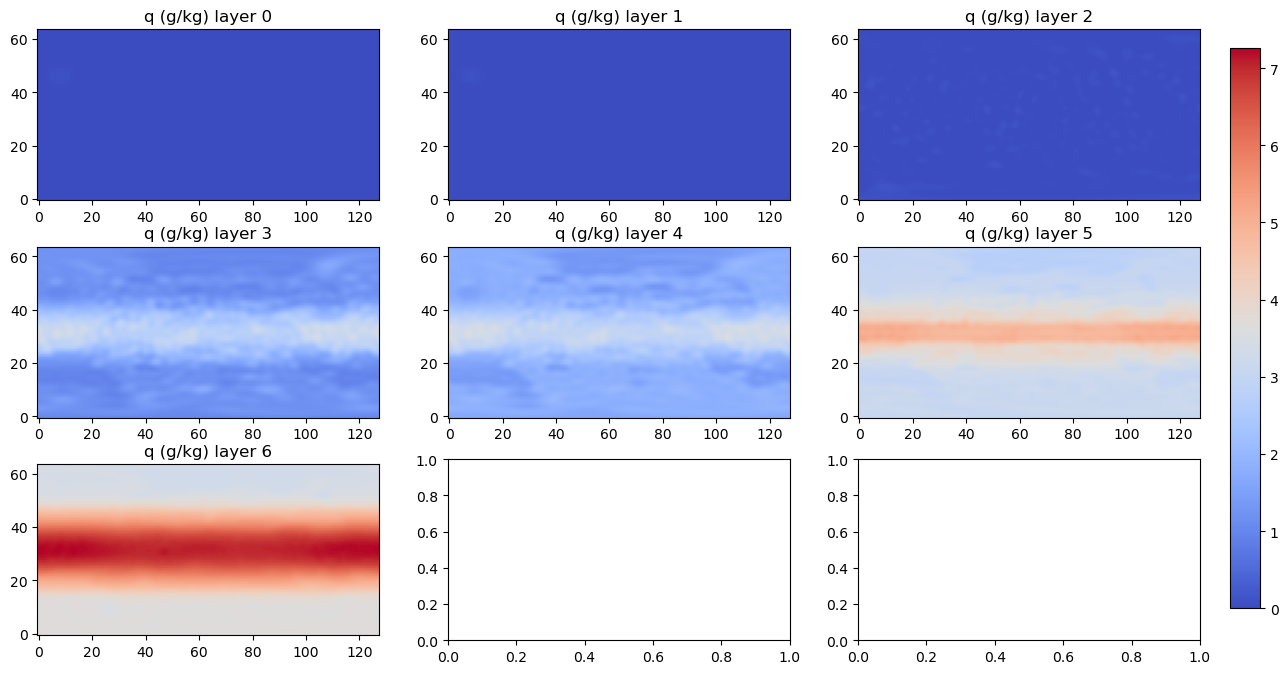

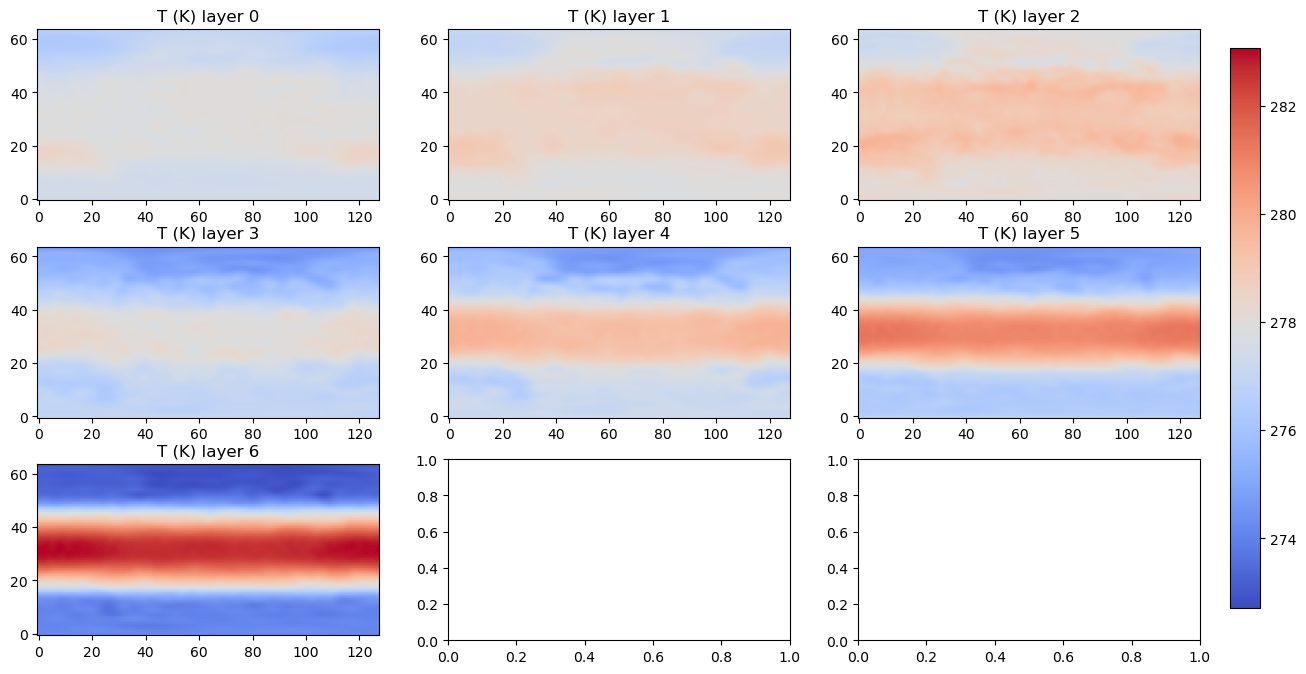

In [6]:
def top_view (variable, title, level=-1, vmin=None, vmax=None, all_layers=False, positive=False):
    if positive:
        vmin = np.min(variable) if vmin is None else vmin
    if all_layers:
        vmin = min(np.min(variable), -np.max(variable)) if vmin is None else vmin
        vmax = max(np.max(variable), -np.min(variable)) if vmax is None else vmax
        layers = variable.shape[0]
        fig, axs = plt.subplots(3, 3, figsize=(15, 8))
        cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Add an axis for the colorbar
        for i, ax in enumerate(axs.flatten()[:layers]):
            im = ax.imshow(variable[i,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='equal')
            ax.invert_yaxis()
            ax.set_title(f'{title} layer {i}')
        fig.colorbar(im, cax=cax)  # Add the colorbar to the figure
        plt.show()
    else:
        vmin = np.minimum(np.min(variable[level]), -np.max(variable[level])) if vmin is None else vmin
        vmax = np.maximum(np.max(variable[level]), -np.min(variable[level])) if vmax is None else vmax
        plt.imshow(variable[level,:,:].T, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='equal')
        plt.gca().invert_yaxis()
        plt.title(title)
        plt.colorbar(orientation='horizontal')
    plt.show()

top_view(u_nodal, 'u', all_layers=True)

top_view(v_nodal, 'v', all_layers=True)

top_view(w_nodal, 'w', all_layers=True)

top_view(q_nodal, 'q (g/kg)', all_layers=True, vmin=0)

top_view(t_nodal, 'T (K)', all_layers=True, positive=True)

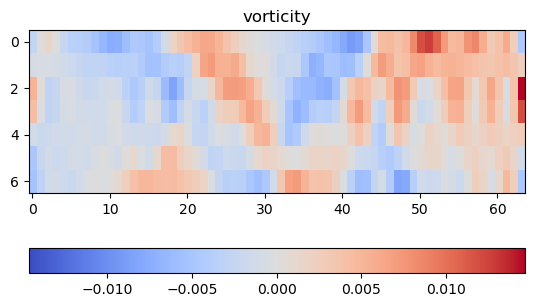

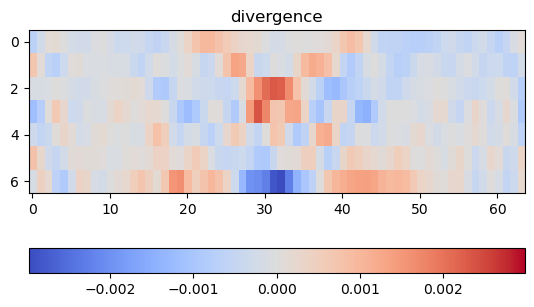

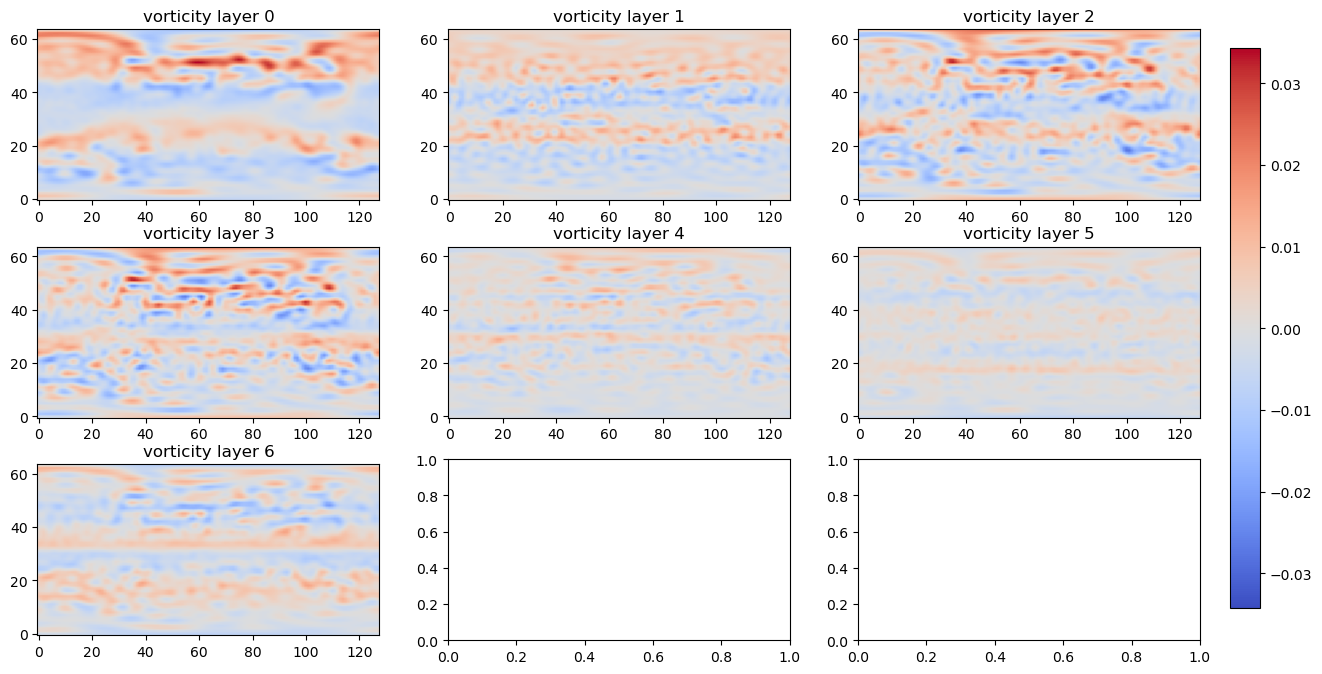

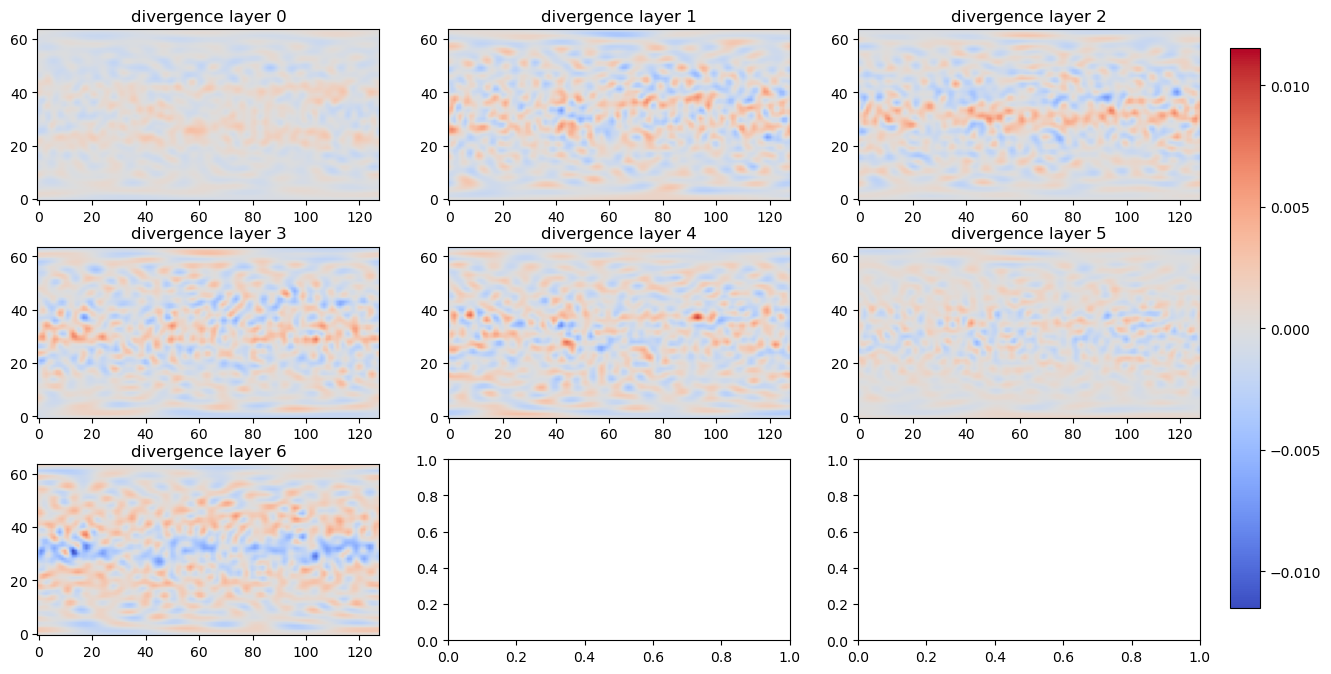

In [7]:
plot_variable(diagnostic_final_state.vorticity, 'vorticity')

plot_variable(diagnostic_final_state.divergence, 'divergence')

top_view(diagnostic_final_state.vorticity, 'vorticity', all_layers=True)

top_view(diagnostic_final_state.divergence, 'divergence', all_layers=True)